In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

# Get data & split into train/test/validation sets

In [93]:
df = pd.read_csv('./Data Exploration/wdbc.csv')
df = df.drop(["Area", "AreaSE", "AreaWorst", "Perimeter", "PerimeterSE", "PerimeterWorst"], axis = 1)
encoder = LabelEncoder().fit(df["B/M"])
df['B/M'] = encoder.transform(df["B/M"])
not_data = ["ID", "B/M"]
label = df["B/M"]
feature = df.drop(not_data, axis = 1)
data = pd.concat([label, feature], axis=1)



In [94]:
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.25, stratify=label, random_state=0 )
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

# Create & Train Initial Model (no tuning)

Our initial model that we train, before hyperparameter tuning. We want a higher Recall, as it accounts for false negatives - and gives us a lower proportion of them, which we desire. We get a very high accuracy and recall and precision - which makes me suspect of overfitting, especially because we have such a small sample size respective to the number of features.

In [95]:
rfc = RandomForestClassifier(random_state=0, n_estimators=10)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_val)

def bench_marks(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')

bench_marks(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        67
           1       1.00      0.88      0.93        40

    accuracy                           0.95       107
   macro avg       0.97      0.94      0.95       107
weighted avg       0.96      0.95      0.95       107

[[67  0]
 [ 5 35]]
Accuracy: 0.9532710280373832
Recall: 0.875
Precision: 1.0


# Feature Selection
Determine importance of each feature, and use recursive feature elimination to determine how many of our features to keep. Then adjust our feature set.

In [102]:
feature_scores = pd.Series(rfc.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print(feature_scores)
feature_scores = feature_scores.index.tolist()

rfc = RandomForestClassifier(random_state=0, n_estimators=100)
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_val)
bench_marks(y_val, y_pred)

rfecv = RFECV(estimator=rfc, step=1, cv=5,scoring='accuracy')
rfecv = rfecv.fit(x_train, y_train)
print(rfecv.n_features_)
print(x_train.columns[rfecv.support_])
feature_select = feature[x_train.columns[rfecv.support_]]

x_train, x_test, y_train, y_test = train_test_split(feature_select, label, test_size=0.25, stratify=label, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

ConcavePoints         0.233947
RadiusWorst           0.193244
ConcavePointsWorst    0.166418
Concavity             0.091073
Radius                0.080469
ConcavityWorst        0.051212
RadiusSE              0.034369
TextureWorst          0.025256
Compactness           0.022305
CompactnessWorst      0.020742
Texture               0.016663
SymmetryWorst         0.016630
SmoothnessWorst       0.013917
ConcavePointsSE       0.012500
Smoothness            0.011721
FractalDimensionSE    0.009536
dtype: float64
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        67
           1       0.93      0.95      0.94        40

    accuracy                           0.95       107
   macro avg       0.95      0.95      0.95       107
weighted avg       0.95      0.95      0.95       107

[[64  3]
 [ 2 38]]
Accuracy: 0.9532710280373832
Recall: 0.95
Precision: 0.926829268292683
15
Index(['Radius', 'Texture', 'Compactness', 'Concavity', 'ConcavePoint

# Hyperparameter Tuning

We will use a random grib with a randomized search to try different iterations of the trees and brute force our way to a optimal solution. We will repeat the code below, adjusting the parameters each iteration.

In [98]:
n_estimators = [int(x) for x in range(50,200,10)]
max_depth = [int(x) for x in np.linspace(5, 150, num = 5)]
max_features = ["sqrt", "log2", None]
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_leaf = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [99]:
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 300, cv = 3, verbose=2, random_state=0, n_jobs = -1)
rf_random.fit(x_train, y_train)
rfc = rf_random.best_estimator_

#validation set
y_pred = rfc.predict(x_val)
print(rf_random.best_estimator_)
print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'Recall: {recall_score(y_val, y_pred)}')
print(f'Precision: {precision_score(y_val, y_pred)}')
print("\n")
#actual test set
y_real_pred = rfc.predict(x_test)
print(f'Accuracy: {accuracy_score(y_test, y_real_pred)}')
print(f'Recall: {recall_score(y_test, y_real_pred)}')
print(f'Precision: {precision_score(y_test, y_real_pred)}')



Fitting 3 folds for each of 300 candidates, totalling 900 fits
RandomForestClassifier(bootstrap=False, max_depth=77, max_features='log2',
                       min_samples_leaf=2, n_estimators=140, random_state=0)
Accuracy: 0.9719626168224299
Recall: 0.975
Precision: 0.9512195121951219


Accuracy: 0.958041958041958
Recall: 0.9622641509433962
Precision: 0.9272727272727272
Fitting 3 folds for each of 300 candidates, totalling 900 fits
RandomForestClassifier(bootstrap=False, max_depth=77, max_features='log2',
                       min_samples_leaf=2, n_estimators=140, random_state=0)
Accuracy: 0.9719626168224299
Recall: 0.975
Precision: 0.9512195121951219


Accuracy: 0.958041958041958
Recall: 0.9622641509433962
Precision: 0.9272727272727272


# Test for over/ underfitting

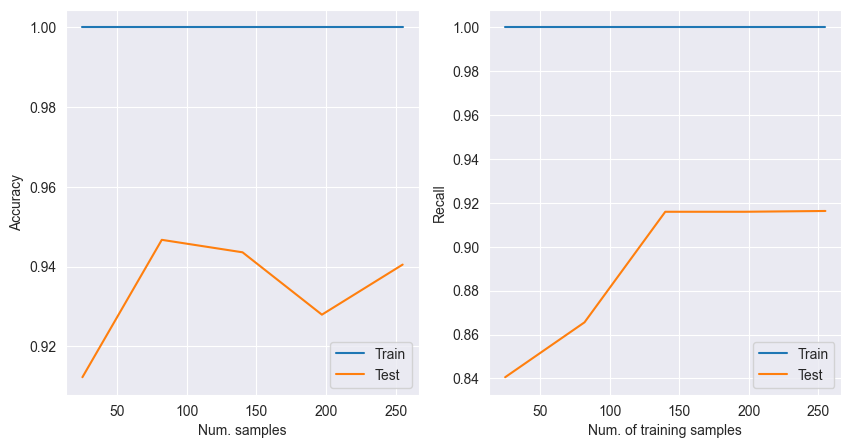

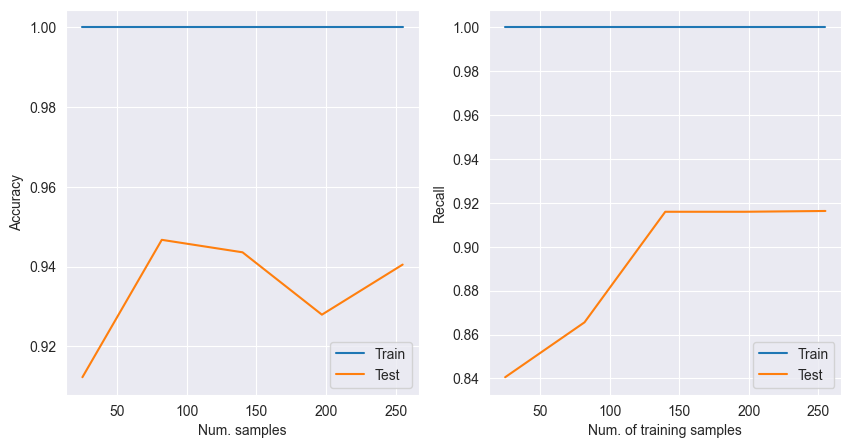

In [100]:
train_sizes_abs_accuracy, train_accuracy, test_accuracy = learning_curve(estimator=rfc, X=x_train, y=y_train, scoring='accuracy', cv=5)

train_sizes_abs_error, train_error, test_error = learning_curve(estimator=rfc, X=x_train, y=y_train, scoring='recall', cv=5)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
train_avg_accuracy, test_avg_accuracy, train_avg_error, test_avg_error = [], [], [], []

for i in range(len(train_sizes_abs_accuracy)):
    train_avg_accuracy.append(np.average(train_accuracy[i]))
    test_avg_accuracy.append(np.average(test_accuracy[i]))

for i in range(len(train_sizes_abs_error)):
    train_avg_error.append(np.average(train_error[i]))
    test_avg_error.append(np.average(test_error[i]))

# Accuracy learning curve
ax[0].plot(train_sizes_abs_accuracy, train_avg_accuracy)
ax[0].plot(train_sizes_abs_accuracy, test_avg_accuracy)
ax[0].legend(['Train', 'Test'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Num. samples')

# Error learning curve
ax[1].plot(train_sizes_abs_error, train_avg_error)
ax[1].plot(train_sizes_abs_error, test_avg_error)
ax[1].legend(['Train', 'Test'])
ax[1].set_xlabel('Num. of training samples')
ax[1].set_ylabel('Recall')
plt.show()

##### before was
100% accuracy and not changing with the number of samples is clearly overfitting, so we will manually remove the least significant variables we calculated to simplify our model - so that we can make up for our lack of instances. When writing up this report, we can do these graphs twice - once with many variable and second with few. We get a higher recall, even though we get a lower precision and accuracy when we use less variables. #When writing up explain why each one

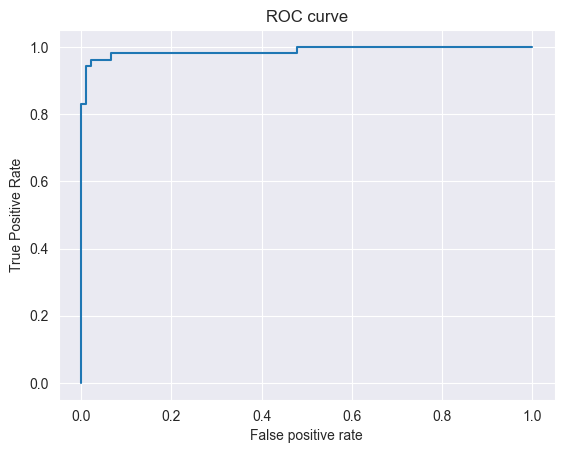

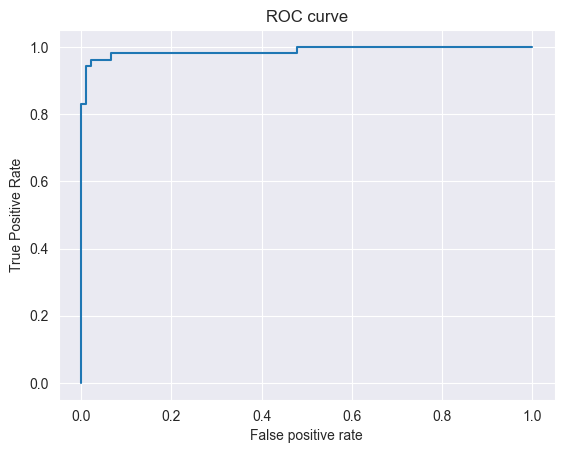

In [101]:
# After hyperparameter tuning* and feature selection*
y_real_pred = rfc.predict(x_test)
auc = roc_auc_score(y_test, y_real_pred)

y_pred_prob = rfc.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True Positive Rate')
plt.show()


We want to minimise false positives..

How does this graph help us? IG I could manually calculate (using the graph) the precesion, accuracy and  recall stats to determine which point is best.